In [69]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import procrustes
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
import anndata as ad

In [70]:
data_folder = '/scratch/ssarnata/persist_project/sc_data_baptiste'

adata_11_1 = sc.read_10x_mtx('%s/filtered_feature_bc_matrix_111' %data_folder, var_names = 'gene_symbols', cache = True)
adata_6_3 = sc.read_10x_mtx('%s/filtered_feature_bc_matrix_63' %data_folder, var_names = 'gene_symbols', cache = True)
adata_8_1 = sc.read_10x_mtx('%s/filtered_feature_bc_matrix_81' %data_folder, var_names = 'gene_symbols', cache = True)

adata_6_3.obs['sample'] = '6_3'
adata_8_1.obs['sample'] = '8_1'
adata_11_1.obs['sample'] = '11_1'

adata_6_3.var_names_make_unique()
adata_8_1.var_names_make_unique()
adata_11_1.var_names_make_unique()

adata = ad.concat([adata_6_3, adata_8_1, adata_11_1])

# adata = adata_11_1.copy()

/projects/users/ssarnata/envs/persist/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [71]:
## Gene panels
panels_path = '/scratch/ssarnata/persist_project/sc_data_baptiste/analysis_output/persist_unsupervised_results_new_data_Baptiste_different_panels.tsv'
panels = pd.read_csv(panels_path, sep='\t', index_col=0)


In [73]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000)
sc.pp.filter_cells(adata, min_genes=200) 
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[:, adata.var.highly_variable].copy()
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
full_pca = adata.obsm['X_pca']

In [74]:
gene_panels = {
    100: [item for item in panels[panels['persist_set_100'] == True].index],
    200: [item for item in panels[panels['persist_set_200'] == True].index],
    300: [item for item in panels[panels['persist_set_300'] == True].index],
    400: [item for item in panels[panels['persist_set_400'] == True].index],
    500: [item for item in panels[panels['persist_set_500'] == True].index],
    600: [item for item in panels[panels['persist_set_600'] == True].index],
    700: [item for item in panels[panels['persist_set_700'] == True].index],
    800: [item for item in panels[panels['persist_set_800'] == True].index],
}

In [75]:
for panel_size, genes in gene_panels.items():
    print(panel_size, genes)

100 ['Nuak', 'ich', 'HB{}1605', '5-HT2A', 'pros', 'pnr', 'srp', 'zfh1', 'fkh', 'Fer2LCH', 'timeout', 'Obp99a', 'hh', 'klg', 'stumps', 'cwo', 'Nsf2', 'cpo', 'roo{}1189', 'aux', 'sals', 'ttk', 'ems', 'TfIIFbeta', 'CG1218', 'CG1146', 'roo{}1055', 'gogo', 'CG11583', 'rols', 'GlcAT-P', 'SNCF', 'GstO2', 'Neurl4', 'CG43980', 'scrt', 'vvl', 'GluRIB', 'CG5151', 'E(z)', 'Sh3beta', 'Blimp-1', 'Ctl1', 'kni', 'Tmhs', 'Pura', 'Sarm', 'lncRNA:CR43887', 'Alk', 'cyp33', 'CG42524', 'Sox14', 'Prp19', 'dve', 'inv', 'otk', 'Drat', 'Idgf6', 'ktub', 'CG8654', 'rooA{}4276', 'roo{}862', 'lncRNA:CR44504', 'VepD', 'Optix', 'Dll', 'magu', 'otp', 'bou', 'Nadsyn', 'sisA', 'Pde9', 'cac', 'prage', 'CG9650', 'mthl1', 'be', 'oc', 'AstA-R1', 'lncRNA:roX2', 'bi', 'cv', 'Stt3A', 'lncRNA:CR44886', 'lncRNA:CR45361', 'Rca1', 'prd', 'lncRNA:CR44396', 'dpp', 'Ufd4', 'Cpr', 'msl-2', 'CG5861', 'Gdi', 'tsh', 'crol', 'pdm2', 'bowl', 'toy', 'mav']
200 ['mld', 'htl', 'ich', 'tok', 'lncRNA:CR44931', 'Hmgcr', 'EloB', 'GlyS', 'pnr', 'C

In [76]:
results = []

for panel_size, genes in gene_panels.items():
    print(f"Evaluating panel of size {panel_size}")
    genes_present = [gene for gene in genes if gene in adata.var_names]
    print(f"Number of genes present in panel: {len(genes_present)}")
    ad = adata[:, genes_present].copy()
    sc.pp.scale(ad)
    sc.tl.pca(ad, svd_solver='arpack', n_comps=30)
    panel_pca = ad.obsm['X_pca']

    # KNN preservation
    k = 15
    nn_full = NearestNeighbors(n_neighbors=k).fit(full_pca).kneighbors(return_distance=False)
    nn_panel = NearestNeighbors(n_neighbors=k).fit(panel_pca).kneighbors(return_distance=False)
    knn_overlap = np.mean([len(set(nn_full[i]) & set(nn_panel[i])) / k for i in range(full_pca.shape[0])])

    # Distance correlation
    dist_full = squareform(pdist(full_pca, metric='euclidean'))
    dist_panel = squareform(pdist(panel_pca, metric='euclidean'))
    triu_idx = np.triu_indices_from(dist_full, k=1)
    spearman_corr = np.corrcoef(dist_full[triu_idx], dist_panel[triu_idx])[0, 1]

    # Procrustes UMAP similarity
    sc.pp.neighbors(ad, use_rep='X_pca')
    sc.tl.umap(ad)
    sc.pp.neighbors(adata, use_rep='X_pca')  # reuse full data
    sc.tl.umap(adata)

    _, _, disparity = procrustes(adata.obsm['X_umap'], ad.obsm['X_umap'])
    results.append({
        'panel_size': panel_size,
        'knn_preservation': knn_overlap,
        'distance_corr': spearman_corr,
        'umap_disparity': disparity
    })

Evaluating panel of size 100
Number of genes present in panel: 100
Evaluating panel of size 200
Number of genes present in panel: 200
Evaluating panel of size 300
Number of genes present in panel: 300
Evaluating panel of size 400
Number of genes present in panel: 400
Evaluating panel of size 500
Number of genes present in panel: 500
Evaluating panel of size 600
Number of genes present in panel: 600
Evaluating panel of size 700
Number of genes present in panel: 700
Evaluating panel of size 800
Number of genes present in panel: 800


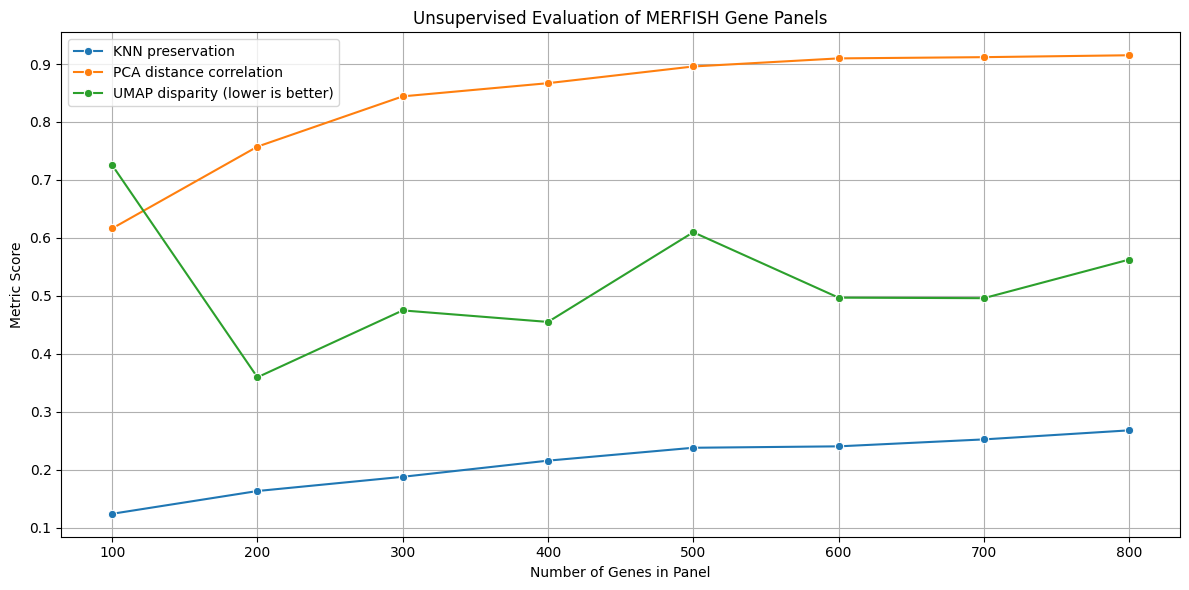

In [77]:
# Plotting
df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="panel_size", y="knn_preservation", marker="o", label="KNN preservation")
sns.lineplot(data=df, x="panel_size", y="distance_corr", marker="o", label="PCA distance correlation")
sns.lineplot(data=df, x="panel_size", y="umap_disparity", marker="o", label="UMAP disparity (lower is better)")
plt.xlabel("Number of Genes in Panel")
plt.ylabel("Metric Score")
plt.title("Unsupervised Evaluation of MERFISH Gene Panels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()